# Train a Bayesian Layer Model for MNIST classification

In this notebook, we will train an MNIST convolutional classifier with a Bayesian last layer. First, we train a determinstic classifier to obtain a MAP estimate of the weights. Then, we replace the last layer of this model with a Bayesian last layer and train the layer using Variational Inference (we keep the backbone fixed).

We allow a choice between:
- Classifier dominated backbone
- Joint training backbone
- Autoencoder dominated backbone

## Setup


In [1]:
inDrive = True

In [2]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Hybrid-CLUE/MyImplementation/testing_notebooks')
    import sys

    # Add the parent directory to the system path
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    sys.path.insert(0, parent_dir)

Mounted at /content/drive


Import libraries

In [3]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler
import models.regene_models


Set the configuration

In [4]:
# 1. Configuration
class Config:
    # Data
    batch_size = 512

    # BLL training
    bll_epochs = 100
    bll_lr = 0.001
    patience = 10
    latent_dim = 256

    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'

cfg = Config()

Load the Datasets

In [5]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

In [6]:
models_dir = '../model_saves/new_regene_models'
results_dir = '../results/new_regene_models'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Backbone
We'll start with the backbone loading. Options are either classifier_dominated, joint_training, or autoencoder_dominated.

In [7]:
classifier_dominated = True
joint_training = False
autoencoder_dominated = False

### Load chosen model

Load model

In [8]:
importlib.reload(models.regene_models)

decoder = models.regene_models.Decoder(latent_dim=cfg.latent_dim, device=cfg.device)
backbone = models.regene_models.Classifier(latent_dim=cfg.latent_dim, num_classes=10, device=cfg.device)

if classifier_dominated:
    backbone.load(models_dir + '/classifier_dominated_classifier_256.pt')
    decoder.load(models_dir + '/classifier_dominated_decoder_256.pt')
    name = 'classifier_dominated'
elif joint_training:
    backbone.load(os.path.join(models_dir, 'joint_classifier_256.pt'))
    decoder.load(os.path.join(models_dir, 'joint_decoder_256.pt'))
    name = 'joint_training'
elif autoencoder_dominated:
    backbone.load(models_dir + '/autoencoder_dominated_classifier_full_256.pt')
    decoder.load(models_dir + '/autoencoder_dominated_decoder_256.pt')
    name = 'autoencoder_dominated'

/content/drive/My Drive/Hybrid-CLUE/MyImplementation/models/regene_models.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, m

Loaded classifier model from: ../model_saves/new_regene_models/classifier_dominated_classifier_256.pt


/content/drive/My Drive/Hybrid-CLUE/MyImplementation/models/regene_models.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, m

Loaded decoder model from: ../model_saves/new_regene_models/classifier_dominated_decoder_256.pt


## Bayesian Last Layer - VI
Next we'll train a variational inference version of the Bayesian last layer using the chosen backbone.


In [9]:
%pip install torchbnn

### Load the model

In [10]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

bll_vi = BayesianLastLayerVI(
    backbone=backbone,
    input_dim=cfg.latent_dim,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    device=cfg.device
)

# Verify all model components are on the correct device
print(f"Backbone device: {next(bll_vi.backbone.parameters()).device}")
print(f"Last layer device: {next(bll_vi.last_layer.parameters()).device}")

Backbone device: cuda:0
Last layer device: cuda:0


### Train the model

In [11]:
from train import train_BLL_VI_classification
importlib.reload(train)

vi_cost_tr, vi_cost_dev, vi_err_tr, vi_err_dev, vi_kl = train_BLL_VI_classification(
    net=bll_vi,
    batch_size=cfg.batch_size,
    nb_epochs=cfg.bll_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    lr=cfg.bll_lr,
    patience=cfg.patience,
    nb_its_dev=1,
    model_saves_dir=models_dir,
    model_name=name
)


Bayesian Last Layer (VI):
it 0/100, Jtr = 0.008, err = 0.491, KL = 0.050,    time: 4.912337 seconds

    Jdev = 0.025, err = 0.009

best validation error
it 1/100, Jtr = 0.001, err = 0.134, KL = 0.070,    time: 2.580986 seconds

    Jdev = 0.011, err = 0.003

best validation error
it 2/100, Jtr = 0.001, err = 0.066, KL = 0.084,    time: 2.433346 seconds

    Jdev = 0.011, err = 0.004

it 3/100, Jtr = 0.000, err = 0.047, KL = 0.092,    time: 2.455884 seconds

    Jdev = 0.010, err = 0.003

it 4/100, Jtr = 0.000, err = 0.043, KL = 0.098,    time: 2.318882 seconds

    Jdev = 0.008, err = 0.002

best validation error
it 5/100, Jtr = 0.000, err = 0.025, KL = 0.102,    time: 2.383281 seconds

    Jdev = 0.008, err = 0.002

best validation error
it 6/100, Jtr = 0.000, err = 0.028, KL = 0.104,    time: 2.482717 seconds

    Jdev = 0.006, err = 0.002

best validation error
it 7/100, Jtr = 0.000, err = 0.027, KL = 0.107,    time: 2.355009 seconds

    Jdev = 0.007, err = 0.002

it 8/100, Jtr =

<Figure size 640x480 with 0 Axes>

### Test the model
To check for Bayesian behaviour, we find an uncertain prediction and visualize multiple samples from the posterior.


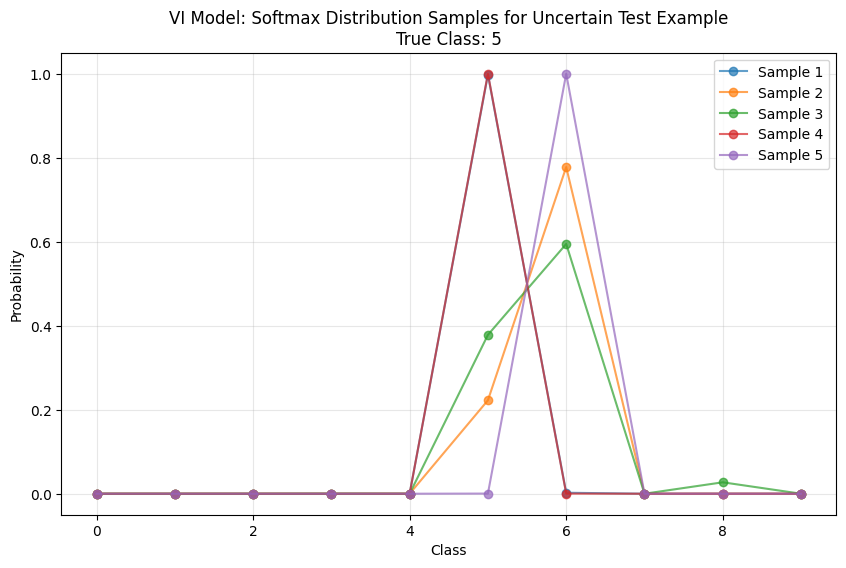

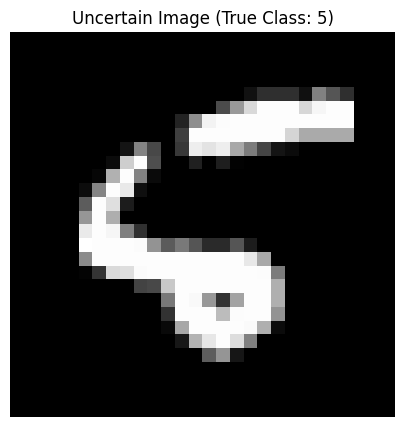

In [14]:
import torch.nn.functional as F

# Search for an uncertain prediction and visualize multiple samples
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100
num_samples = 5

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]

            # Get multiple predictions for this single example
            outputs = []
            with torch.no_grad():  # Add no_grad context
                for _ in range(num_samples):
                    logits = bll_vi(x_single)
                    probs = F.softmax(logits, dim=1)
                    outputs.append(probs)

            # Stack predictions
            probs = torch.stack(outputs)  # Shape: [num_samples, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [num_samples, num_classes]

            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.9:  # If average confidence is less than 60%
                found_uncertain = True
                break

except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(num_samples):
    plt.plot(x_axis, probs[i].detach().cpu().numpy(), 'o-', alpha=0.7, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'VI Model: Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()

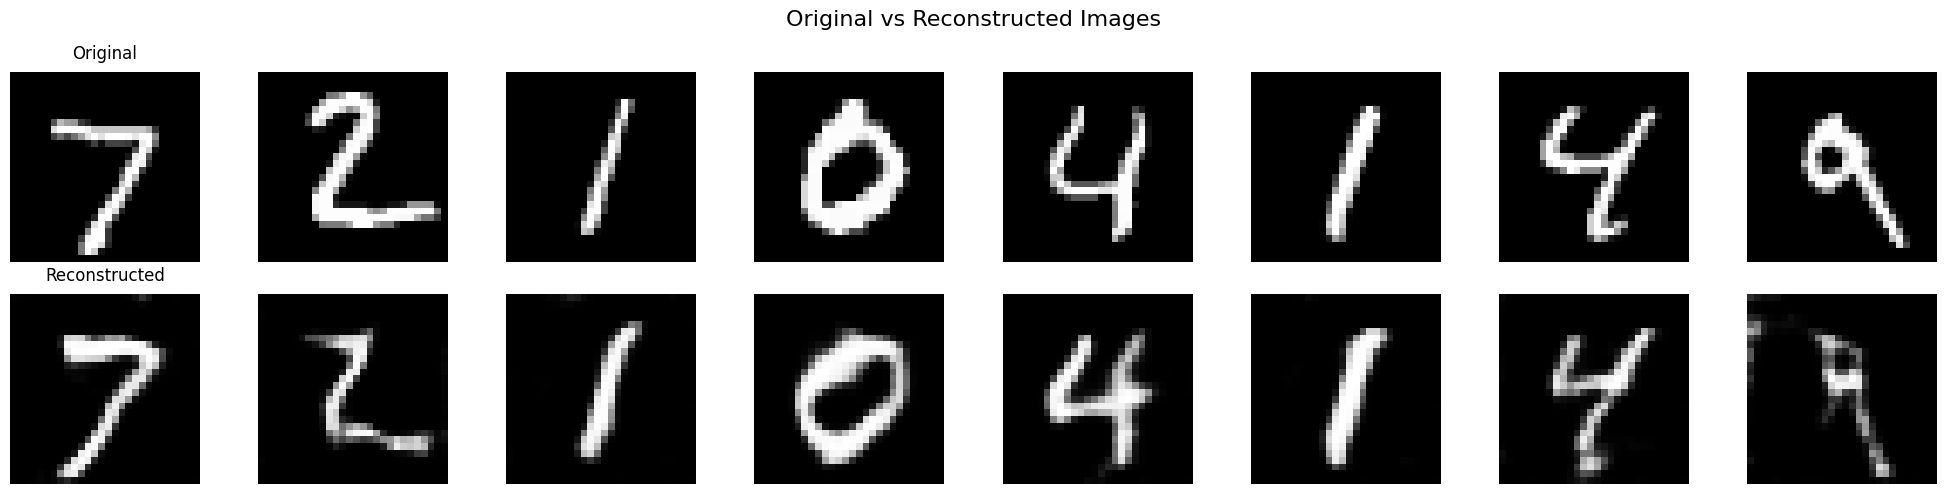

Reconstruction MSE: 0.0526


In [13]:
# Get test images
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(cfg.device)

# Get reconstructions using the classifier and decoder
with torch.no_grad():
    # Get latent representations from classifier
    latent_reps, _ = backbone(test_images)  # Returns (latent_rep, logits)
    # Reconstruct using decoder
    reconstructions = decoder(latent_reps)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

# Plot original images
for i in range(8):
    axes[0,i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

# Plot reconstructions
for i in range(8):
    axes[1,i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()

# Optionally, calculate reconstruction error
mse = nn.MSELoss()
recon_error = mse(reconstructions, test_images)
print(f'Reconstruction MSE: {recon_error.item():.4f}')